In [ ]:
#install libraries

!pip install pycox torchtuples

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 25.1 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2434 sha256=e1d98e71defc0e6f4bb840edee6862735cd60b1312deba6ba1d6fd0572654755
  Stored in directory: /root/.cache/pip/wheels/77/5b/0e/0e63d10b6353208a085a321ea2eed2578f220a77bb8a4bd7ab
Successfully built feather-format


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
import torchtuples as tt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Practicum Models/survival_episodes_cleaned.csv')
df

,randid,start_date,duration,event_observed,NOAAClimRegion,TempZone,HumidZone,bin_PlantSize_kW,plant_age_months,active_snow_tickets,snow_bin_ticket_minutes,snow_affected_assets,snow_production_level,snow_value_mm,total_daily_snow_mm,low_irradiation,cumulative_snow_mm,hurr_bin_ticket_minutes,hurr_affected_assets,hurr_production_level,HurricanePrep,HurricanePostInspection,hurricane,nearest_hurricane,wind_speed_mean,rain_value_mm,nearest_rain,storm_active_tickets,storm_bin_ticket_minutes,storm_affected_assets,storm_production_level,lightning,storm,duration_minutes_storm,nearest_storm,flood,duration_minutes_flood,nearest_flood,rain,weather_onset
0,C2S1,2018-10-13,1,1,West,T6,H4,large,25.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,2.677792,0.017805,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
1,C2S1,2018-11-22,3,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.930521,1.136330,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
2,C2S1,2018-11-29,3,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,1,0.0,NaN,NaN,Unknown,No,No,0.0,354,5.715604,8.015464,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
3,C2S1,2018-11-30,2,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,1,0.0,NaN,NaN,Unknown,No,No,0.0,354,7.684687,0.239059,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
4,C2S1,2018-12-05,2,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,1,0.0,NaN,NaN,Unknown,No,No,0.0,354,1.672604,0.396306,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7266,P2S1,2019-03-08,3,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.936458,0.425360,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
7267,P2S1,2019-03-20,10,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,3.394271,1.412394,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
7268,P2S1,2019-03-21,9,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.167917,3.042049,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
7269,P2S1,2019-03-22,8,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.028187,0.000410,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1


In [ ]:
X = df.drop(columns=['duration', 'event_observed', 'start_date', 'randid'], errors='ignore')
y_duration = df['duration'].values
y_event = df['event_observed'].values

cat_cols = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype('float32')

X_train, X_test, y_train_dur, y_test_dur, y_train_evt, y_test_evt = train_test_split(
    X_scaled, y_duration, y_event, test_size=0.2, random_state=42)


In [ ]:
X_train.shape, X_test.shape, y_train_dur.shape, y_test_dur.shape, y_train_evt.shape, y_test_evt.shape

((5816, 58), (1455, 58), (5816,), (1455,), (5816,), (1455,))

In [ ]:
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

num_durations = 150
labtrans = LabTransDiscreteTime(num_durations)

y_train = labtrans.fit_transform(y_train_dur, y_train_evt)
y_test = labtrans.transform(y_test_dur, y_test_evt)

In [ ]:
class LogisticNet(nn.Module):
    def __init__(self, in_features, num_nodes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, num_nodes),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(num_nodes),
            nn.Dropout(0.1),
            nn.Linear(num_nodes, num_nodes // 2),
            nn.LeakyReLU(0.01),
             nn.BatchNorm1d(num_nodes // 2),
            nn.Linear(num_nodes // 2, labtrans.out_features)
        )

    def forward(self, x):
        return self.net(x)

in_features = X_train.shape[1]
net = LogisticNet(in_features, num_nodes=128)
model = LogisticHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)
model.optimizer.set_lr(1e-3)

In [ ]:
batch_size = 256
epochs = 512
callbacks = [tt.callbacks.EarlyStopping(patience=15)]

log = model.fit(X_train, y_train, batch_size, epochs,
                callbacks, verbose=True, val_data=(X_test, y_test))

0:	[0s / 0s],		train_loss: 14.3874,	val_loss: 11.2831
1:	[0s / 0s],		train_loss: 10.3465,	val_loss: 7.6977
2:	[0s / 0s],		train_loss: 7.5783,	val_loss: 5.9680
3:	[0s / 0s],		train_loss: 6.0270,	val_loss: 5.0721
4:	[0s / 0s],		train_loss: 5.1469,	val_loss: 4.3371
5:	[0s / 0s],		train_loss: 4.4280,	val_loss: 3.8129
6:	[0s / 0s],		train_loss: 3.9100,	val_loss: 3.3956
7:	[0s / 1s],		train_loss: 3.4538,	val_loss: 3.1021
8:	[0s / 1s],		train_loss: 3.1027,	val_loss: 2.8426
9:	[0s / 1s],		train_loss: 2.8924,	val_loss: 2.7134
10:	[0s / 1s],		train_loss: 2.7087,	val_loss: 2.6119
11:	[0s / 1s],		train_loss: 2.5902,	val_loss: 2.5247
12:	[0s / 1s],		train_loss: 2.5487,	val_loss: 2.4876
13:	[0s / 1s],		train_loss: 2.4817,	val_loss: 2.4419
14:	[0s / 2s],		train_loss: 2.4490,	val_loss: 2.4065
15:	[0s / 2s],		train_loss: 2.4215,	val_loss: 2.3918
16:	[0s / 2s],		train_loss: 2.3846,	val_loss: 2.3849
17:	[0s / 2s],		train_loss: 2.3621,	val_loss: 2.3738
18:	[0s / 2s],		train_loss: 2.3515,	val_loss: 2.3666


In [ ]:
surv = model.predict_surv_df(X_test)

ev = EvalSurv(surv, y_test_dur, y_test_evt, censor_surv='km')
print("LogisticHazard C-index:", ev.concordance_td('antolini'))

LogisticHazard C-index: 0.7467233219638335


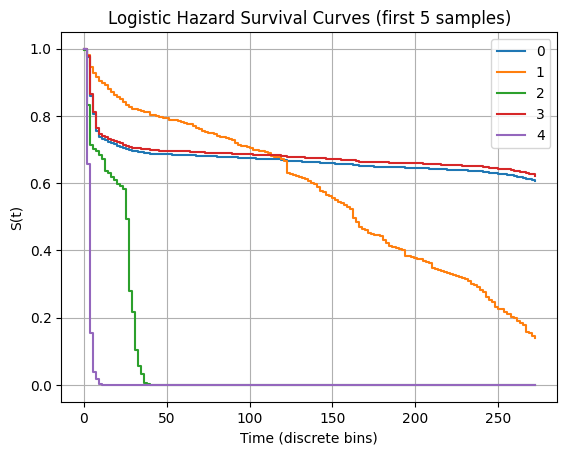

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t)')
plt.xlabel('Time (discrete bins)')
plt.title('Logistic Hazard Survival Curves (first 5 samples)')
plt.grid(True)
plt.show()